In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 14.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [4]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current CUDA device:", torch.cuda.current_device())


PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA device count: 1
GPU Name: Tesla T4
Current CUDA device: 0


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
train_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/train_data.csv'
test_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/test_data.csv'

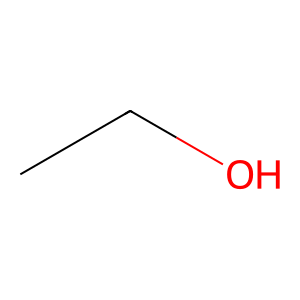

In [7]:
class MoleculeVisualizer():
    def visualize_molecule_2D(self,smiles):
        """
        Generates a 2D image of the molecule from its SMILES representation.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Invalid SMILES string.")
            return

        img = Draw.MolToImage(mol, size=(300, 300))

        return img

visualizer = MoleculeVisualizer()
visualizer.visualize_molecule_2D('CCO')

In [8]:
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

X_cols = ['sci_name','name','cid','smile','Molecular Weight','LogP','TPSA','Rotatable Bonds','H Bond Donors','H Bond Acceptors','Aromatic Rings','Num Rings','Atom Count','coulomb_matrix','embeddings']
y_cols = ['a', 'b']

X_train = train_data[X_cols]
y_train = train_data[y_cols]
X_test = test_data[X_cols]
y_test = test_data[y_cols]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 15) (165, 2) (55, 15) (55, 2)


In [9]:
a_mean = y_train['a'].mean()
b_mean = y_train['b'].mean()

diff = a_mean / b_mean
print(diff)

159.90314965096417


[00:10:44] WARNING: not removing hydrogen atom without neighbors


(165, 300, 300, 3) (55, 300, 300, 3)


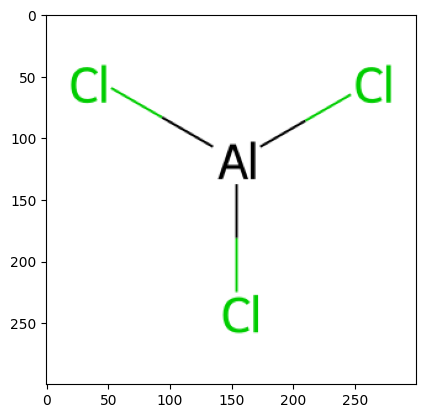

In [104]:
train_imgs = []
test_imgs = []

for smile in X_train['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    train_imgs.append(np.array(img, dtype=np.float32))

for smile in X_test['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    test_imgs.append(np.array(img, dtype=np.float32))

train_imgs = np.array(train_imgs, dtype=np.uint8)
test_imgs = np.array(test_imgs, dtype=np.uint8)
plt.imshow(test_imgs[0])

print(train_imgs.shape, test_imgs.shape)

In [98]:
class EOSDataset(Dataset):

  def __init__(self, imgs, y, scale=True):
    self.imgs = imgs
    self.y = y.values.astype(np.float32)
    self.img_transform = transforms.Compose([
      #transforms.Lambda(lambda img: img.transpose(1, 2, 0)),  # Convert (C, H, W) -> (H, W, C)
      transforms.ToTensor(),  # Now ToTensor() will work correctly
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])


    # Separate scalers for a and b
    self.scaler_a = StandardScaler()
    self.scaler_b = StandardScaler()

    # Fit scalers on the respective columns
    if scale:
      self.y[:, 0] = self.scaler_a.fit_transform(self.y[:, 0].reshape(-1, 1)).reshape(-1)
      self.y[:, 1] = self.scaler_b.fit_transform(self.y[:, 1].reshape(-1, 1)).reshape(-1)


  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    label = self.y[idx]
    img = self.transform(img)

    return img, label

  def transform(self, img):
    return self.img_transform(img)

  def inverse_transform(self, img_tensor):
    """
    Convert a normalized tensor back to a NumPy array in (H, W, C) format.
    """
    # Inverse normalization: x' = x * std + mean
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    # Convert to NumPy (C, H, W) → (H, W, C)
    img = img_tensor.clone().detach().cpu().numpy()
    img = img * std[:, None, None] + mean[:, None, None]  # Undo normalization
    img = np.clip(img, 0, 1)  # Ensure values are in range [0,1]
    img = (img * 255).astype(np.uint8)  # Convert to [0,255] for visualization
    img = np.transpose(img, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)

    return img


In [168]:
class CNN(nn.Module):

  def __init__(self, train_dataset, test_dataset):
    super(CNN, self).__init__()

    self.cnn_pipeline = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, padding=2),  # Change 7x7 → 5x5
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # Additional layer for more complex structures
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2)  # More downsampling
    )

    # Forward pass a dummy tensor to determine output shape
    IMAGE_HEIGHT = train_dataset[0][0].shape[1]
    IMAGE_WIDTH = train_dataset[0][0].shape[2]

    with torch.no_grad():
        dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)  # Adjust to your dataset's image size
        dummy_output = self.cnn_pipeline(dummy_input)
        flattened_size = dummy_output.view(1, -1).shape[1]  # Get feature size after CNN

    self.fc_pipeline = nn.Sequential(
        nn.Linear(flattened_size, 128),
        nn.ReLU(),
        nn.Dropout(0.1),  # Increased dropout to 30%
        nn.Linear(128, 64),
        nn.ReLU(),
    )

    self.output_layer = nn.Linear(64, 2)

    self.train_dataset = train_dataset
    self.test_dataset = test_dataset


    self.train_loader = DataLoader(self.train_dataset, batch_size=8, shuffle=True)
    self.test_loader = DataLoader(self.test_dataset, batch_size=8, shuffle=False)

    self._initialize_weights()

  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

  # For training model on a and b and getting embedded vector for PKAN
  def forward(self, x, predict=False):
    x = self.cnn_pipeline(x)
    x = torch.flatten(x, 1)
    x = self.fc_pipeline(x)
    if predict:
        x = self.output_layer(x)
    return x

  def unscale_predict(self, x, train=True):
    x = x.detach().cpu().numpy()
    if train:
      scaler_a = self.train_dataset.scaler_a
      scaler_b = self.train_dataset.scaler_b
    else:
      scaler_a = self.test_dataset.scaler_a
      scaler_b = self.test_dataset.scaler_b

    x[:, 0] = scaler_a.inverse_transform(x[:, 0].reshape(-1, 1)).reshape(-1)
    x[:, 1] = scaler_b.inverse_transform(x[:, 1].reshape(-1, 1)).reshape(-1)
    return x

  def weighted_loss(self, outputs, labels):
    criterion = nn.SmoothL1Loss()
    loss = criterion(outputs, labels)
    weight = torch.tensor([1.0, 80], device=device)  # Adjust if needed
    return (loss * weight).mean()

  def train_model(self, epochs, learning_rate, step_size, gamma):
    #optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    self.to(device)  # Move the model to the device (GPU if available)

    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(self.train_loader, 0):
            inputs, labels = data  # Get the inputs and labels from the data loader
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = self(inputs, predict=True)  # Forward pass
            loss = self.weighted_loss(outputs, labels)  # Calculate the loss
            loss_history.append(loss.item())
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters

            running_loss += loss.item()  # Accumulate the loss for the epoch

        scheduler.step()

        # Print the average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(self.train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    print("Training finished!")

    self.to(device)

  def validate(self):
      total_loss = 0.0
      all_outputs = []
      all_labels = []

      with torch.no_grad():  # Disable gradient computation
          for data in self.test_loader:
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = self(inputs, predict=True)
              loss = self.weighted_loss(outputs, labels)
              total_loss += loss.item()

              all_outputs.append(outputs.cpu().numpy())
              all_labels.append(labels.cpu().numpy())

      avg_loss = total_loss / len(self.test_loader)
      print(f"Validation Loss: {avg_loss:.4f}")

      # Convert lists to numpy arrays for better analysis
      all_outputs = np.concatenate(all_outputs, axis=0)
      all_labels = np.concatenate(all_labels, axis=0)

      # Unscale predictions
      unscaled_outputs = self.unscale_predict(torch.tensor(all_outputs), train=False)
      unscaled_labels = self.unscale_predict(torch.tensor(all_labels), train=False)

      # Compute evaluation metrics
      mae = np.mean(np.abs(unscaled_outputs - unscaled_labels), axis=0)
      mse = np.mean((unscaled_outputs - unscaled_labels) ** 2, axis=0)

      print(f"Mean Absolute Error (MAE): a={mae[0]:.4f}, b={mae[1]:.4f}")
      print(f"Mean Squared Error (MSE): a={mse[0]:.4f}, b={mse[1]:.4f}")



In [144]:
train_dataset = EOSDataset(train_imgs, y_train, True)
test_dataset = EOSDataset(test_imgs, y_test, True)

Epoch [1/50] Loss: 215.5675 | LR: 0.000100
Epoch [2/50] Loss: 16.8082 | LR: 0.000100
Epoch [3/50] Loss: 14.2800 | LR: 0.000100
Epoch [4/50] Loss: 12.9457 | LR: 0.000100
Epoch [5/50] Loss: 15.2540 | LR: 0.000100
Epoch [6/50] Loss: 14.3046 | LR: 0.000100
Epoch [7/50] Loss: 13.7142 | LR: 0.000100
Epoch [8/50] Loss: 13.5518 | LR: 0.000100
Epoch [9/50] Loss: 12.1693 | LR: 0.000100
Epoch [10/50] Loss: 10.5035 | LR: 0.000090
Epoch [11/50] Loss: 9.9314 | LR: 0.000090
Epoch [12/50] Loss: 11.4370 | LR: 0.000090
Epoch [13/50] Loss: 9.5360 | LR: 0.000090
Epoch [14/50] Loss: 13.0135 | LR: 0.000090
Epoch [15/50] Loss: 13.8322 | LR: 0.000090
Epoch [16/50] Loss: 11.4818 | LR: 0.000090
Epoch [17/50] Loss: 12.4328 | LR: 0.000090
Epoch [18/50] Loss: 10.8183 | LR: 0.000090
Epoch [19/50] Loss: 9.5215 | LR: 0.000090
Epoch [20/50] Loss: 10.7828 | LR: 0.000081
Epoch [21/50] Loss: 11.6471 | LR: 0.000081
Epoch [22/50] Loss: 11.3057 | LR: 0.000081
Epoch [23/50] Loss: 8.4988 | LR: 0.000081
Epoch [24/50] Loss: 7.2

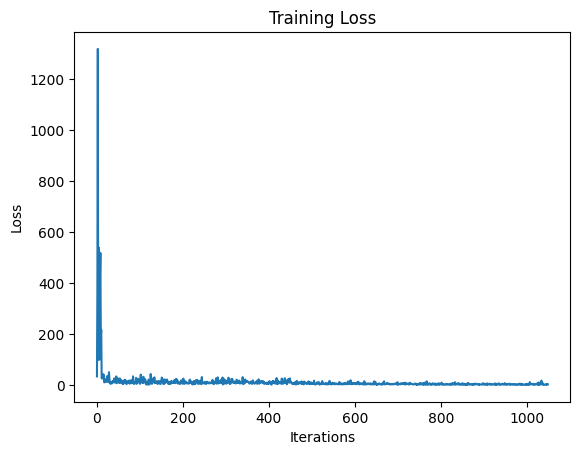

Training finished!


In [166]:
cnn = CNN(train_dataset, test_dataset)
cnn.train_model(epochs=50, learning_rate=0.0001, step_size=10, gamma=0.9)

In [136]:
cnn.validate()

Validation Loss: 10.6959
Mean Absolute Error (MAE): a=7.7274, b=0.0461
Mean Squared Error (MSE): a=131.6160, b=0.0090


In [93]:
img, label = train_dataset.__getitem__(60)

print(cnn.unscale_predict(torch.tensor(label.reshape(-1,2)).to(device)))
encoding = cnn.unscale_predict(cnn(img.to(device).unsqueeze(0), predict=True))

print(encoding)

[[40.32   0.192]]
[[44.546227    0.24054514]]


In [123]:
def visualize_feature_maps(model, image):
    """
    Visualizes the feature maps from each convolutional layer of the model.

    :param model: The trained CNN model.
    :param image: A single image, either as a NumPy array (H, W, C) or a PyTorch tensor (C, H, W).
    """
    model.eval()  # Set model to evaluation mode

    # Detect device
    device = next(model.parameters()).device  # Get model's device (CPU or GPU)

    # Ensure image is a PyTorch tensor
    if isinstance(image, np.ndarray):
        image = torch.tensor(image).permute(2, 0, 1)  # Convert (H, W, C) → (C, H, W)

    # Ensure image is of shape (C, H, W)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)

    # Ensure image is float type and moved to the correct device
    image = image.float().to(device)

    activation_maps = []
    layer_names = []

    x = image  # Now in shape (1, C, H, W)

    for name, layer in model.cnn_pipeline.named_children():
        x = layer(x)
        if isinstance(layer, torch.nn.Conv2d):  # Store feature maps after conv layers
            activation_maps.append(x.cpu().detach().numpy())  # Move to CPU for visualization
            layer_names.append(name)

    # Plot feature maps
    for idx, feature_map in enumerate(activation_maps):
        num_filters = feature_map.shape[1]
        print(f"Layer {layer_names[idx]} - {num_filters} filters")

        # Adjust figure size dynamically based on the number of filters
        fig, axes = plt.subplots(num_filters, 1, figsize=(5, num_filters * 3))
        fig.suptitle(f'Layer {layer_names[idx]}', fontsize=16)

        if num_filters == 1:  # If only one filter, `axes` is not iterable
            axes.imshow(feature_map[0, 0], cmap='viridis')
            axes.axis('off')
        else:
            for i in range(num_filters):
                axes[i].imshow(feature_map[0, i], cmap='viridis')
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

# Example Usage:
# test_image = train_dataset[0][0]  # Get an image from dataset
# visualize_feature_maps(cnn, test_image)


Layer 0 - 32 filters


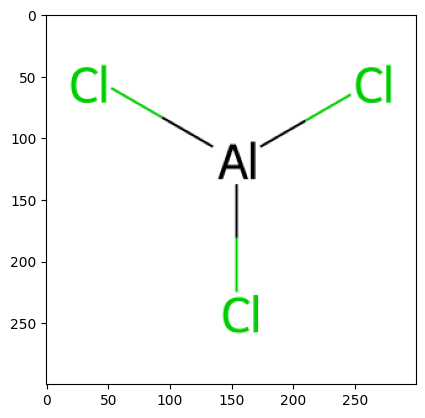

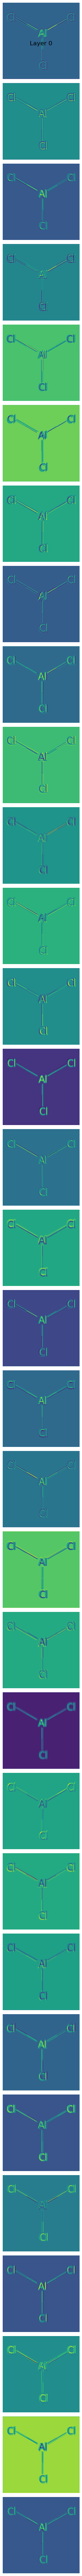

Layer 4 - 64 filters


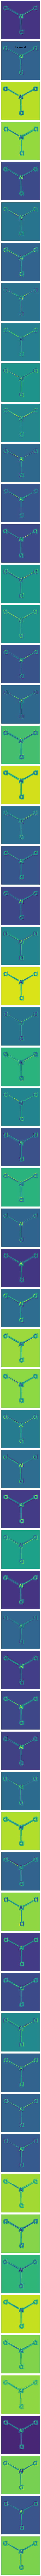

Layer 8 - 128 filters


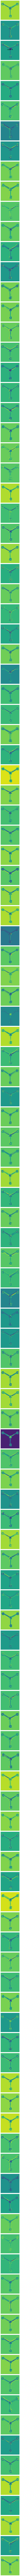

In [124]:
img, _ = test_dataset[0]
img = train_dataset.inverse_transform(img)
plt.imshow(img)

visualize_feature_maps(cnn, test_dataset[0][0])

In [193]:
class CNN_GEN(nn.Module):
    def __init__(self, train_dataset, test_dataset, num_filters=(32, 64, 128, 256), kernel_sizes=(5, 5, 3, 3), dropout_rate=0.1, fc_sizes=(128, 64), optimizer_name="SGD", learning_rate=0.01, momentum=0.9):
        super(CNN_GEN, self).__init__()

        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

        # Define CNN layers with variable filters and kernel sizes
        self.cnn_pipeline = nn.Sequential(
            nn.Conv2d(3, num_filters[0], kernel_size=kernel_sizes[0], padding=kernel_sizes[0]//2),
            nn.BatchNorm2d(num_filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(num_filters[0], num_filters[1], kernel_size=kernel_sizes[1], padding=kernel_sizes[1]//2),
            nn.BatchNorm2d(num_filters[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(num_filters[1], num_filters[2], kernel_size=kernel_sizes[2], padding=kernel_sizes[2]//2),
            nn.BatchNorm2d(num_filters[2]),
            nn.ReLU(),

            nn.Conv2d(num_filters[2], num_filters[3], kernel_size=kernel_sizes[3], padding=kernel_sizes[3]//2),
            nn.BatchNorm2d(num_filters[3]),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the flattened feature size
        IMAGE_HEIGHT = train_dataset[0][0].shape[1]
        IMAGE_WIDTH = train_dataset[0][0].shape[2]

        with torch.no_grad():
            dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
            dummy_output = self.cnn_pipeline(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Fully connected layers with variable sizes
        self.fc_pipeline = nn.Sequential(
            nn.Linear(flattened_size, fc_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_sizes[0], fc_sizes[1]),
            nn.ReLU(),
        )

        self.output_layer = nn.Linear(fc_sizes[1], 2)

        # Create DataLoaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=8, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=8, shuffle=False)

        self._initialize_weights()

        # Set optimizer
        self.optimizer_name = optimizer_name
        self.learning_rate = learning_rate
        self.momentum = momentum
        self._set_optimizer()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _set_optimizer(self):
        if self.optimizer_name == "Adam":
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == "SGD":
            self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, momentum=self.momentum)
        else:
            self.optimizer = optim.RMSprop(self.parameters(), lr=self.learning_rate)

    def forward(self, x, predict=True):
        x = self.cnn_pipeline(x)
        x = torch.flatten(x, 1)
        x = self.fc_pipeline(x)
        if predict:
            x = self.output_layer(x)
        return x

    def unscale_predict(self, x, train=True):
        x = x.detach().cpu().numpy()
        scaler_a = self.train_dataset.scaler_a if train else self.test_dataset.scaler_a
        scaler_b = self.train_dataset.scaler_b if train else self.test_dataset.scaler_b

        x[:, 0] = scaler_a.inverse_transform(x[:, 0].reshape(-1, 1)).reshape(-1)
        x[:, 1] = scaler_b.inverse_transform(x[:, 1].reshape(-1, 1)).reshape(-1)
        return x

    def weighted_loss(self, outputs, labels):
        criterion = nn.SmoothL1Loss()
        loss = criterion(outputs, labels)
        weight = torch.tensor([1.0, 80], device=device)  # Adjust weights if needed
        return (loss * weight).mean()

    def train_model(self, epochs, step_size=10, gamma=0.5):
        scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.to(device)

        loss_history = []
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                self.optimizer.zero_grad()
                outputs = self(inputs, predict=True)
                loss = self.weighted_loss(outputs, labels)
                loss_history.append(loss.item())
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            scheduler.step()
            print(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(self.train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        plt.figure()
        plt.plot(loss_history)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

        print("Training finished!")

    def validate(self):
        total_loss = 0.0
        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for data in self.test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self(inputs, predict=True)
                loss = self.weighted_loss(outputs, labels)
                total_loss += loss.item()

                all_outputs.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_loss = total_loss / len(self.test_loader)
        print(f"Validation Loss: {avg_loss:.4f}")

        all_outputs = np.concatenate(all_outputs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        unscaled_outputs = self.unscale_predict(torch.tensor(all_outputs), train=False)
        unscaled_labels = self.unscale_predict(torch.tensor(all_labels), train=False)

        mae = np.mean(np.abs(unscaled_outputs - unscaled_labels), axis=0)
        mse = np.mean((unscaled_outputs - unscaled_labels) ** 2, axis=0)

        print(f"Mean Absolute Error (MAE): a={mae[0]:.4f}, b={mae[1]:.4f}")
        print(f"Mean Squared Error (MSE): a={mse[0]:.4f}, b={mse[1]:.4f}")


In [215]:
import random
# Ensure CNN model is updated to accept hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torch

def train_and_evaluate(chromosome, model, optimizer, batch_size, num_epochs=10, device="cuda"):
    """
    Train and evaluate a given model with a given optimizer.
    """
    scaler = torch.amp.GradScaler('cuda')

    # Reduce batch size if necessary
    batch_size = max(1, batch_size // 2)

    # Load DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.to(device)  # Move model to GPU
    criterion = nn.SmoothL1Loss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed Precision Training
            with torch.autocast("cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}")

    # Validation with `torch.no_grad()`
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f'Chromosome {chromosome}')

    # Move model to CPU & Free GPU memory
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

    return -avg_loss  # Return negative loss for GA optimization

def fitness_function(chromosome):
    model = CNN_GEN(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        num_filters=(chromosome["num_filters_1"], chromosome["num_filters_2"], chromosome["num_filters_3"], chromosome["num_filters_4"]),
        kernel_sizes=(chromosome["kernel_size_1"], chromosome["kernel_size_2"], chromosome["kernel_size_3"], chromosome["kernel_size_4"]),
        dropout_rate=chromosome["dropout_rate"],
        fc_sizes=(chromosome["fc_size_1"], chromosome["fc_size_2"]),
        optimizer_name=chromosome["optimizer"],
        learning_rate=chromosome["learning_rate"],
        momentum=chromosome["momentum"]
    )
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=chromosome["learning_rate"]),
        "SGD": optim.SGD(model.parameters(), lr=chromosome["learning_rate"], momentum=0.9),
        "RMSprop": optim.RMSprop(model.parameters(), lr=chromosome["learning_rate"]),
    }[chromosome["optimizer"]]
    return -train_and_evaluate(chromosome, model, optimizer, chromosome["batch_size"])

def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        chromosome = {
            "num_filters_1": random.choice([32, 64, 128]),
            "num_filters_2": random.choice([64, 128, 256]),
            "num_filters_3": random.choice([128, 256, 512]),
            "num_filters_4": random.choice([256, 512, 1024]),
            "kernel_size_1": random.choice([3, 5, 7]),
            "kernel_size_2": random.choice([3, 5, 7]),
            "kernel_size_3": random.choice([3, 5, 7]),
            "kernel_size_4": random.choice([3, 5, 7]),
            "dropout_rate": random.uniform(0.0, 0.5),
            "fc_size_1": random.choice([64, 128, 256]),
            "fc_size_2": random.choice([32, 64, 128]),
            "optimizer": random.choice(["SGD", "Adam", "RMSprop"]),
            "learning_rate": random.uniform(0.0001, 0.1),
            "momentum": random.uniform(0.5, 0.99),
            "batch_size": random.choice([8])  # Add this!
        }
        population.append(chromosome)
    return population


def tournament_selection(population, fitness_scores, k=3):
    return sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)[0][0]

def crossover(parent1, parent2):
    child = parent1.copy()
    crossover_point = random.choice(list(parent1.keys()))
    for key in list(parent1.keys())[list(parent1.keys()).index(crossover_point):]:
        child[key] = parent2[key]
    return child

def mutate(individual, mutation_rate=0.2):
    if random.random() < mutation_rate:
        key = random.choice(list(individual.keys()))
        if key == "learning_rate":
            individual[key] = random.choice([0.01, 0.001, 0.0001])
        elif key == "batch_size":
            individual[key] = random.choice([16, 32, 64])
        elif key == "optimizer":
            individual[key] = random.choice(["Adam", "SGD", "RMSprop"])
        elif key in ["num_filters_1", "num_filters_2"]:
            individual[key] = random.choice([32, 64, 128, 256])
        elif key == "dropout_rate":
            individual[key] = random.uniform(0.1, 0.5)
    return individual


In [216]:
import torch
import gc

def run_genetic_algorithm(pop_size=10, generations=5, mutation_rate=0.2):
    # Step 1: Initialize population
    population = initialize_population(pop_size)

    # Step 2: Evaluate initial fitness
    fitness_scores = []
    for ind in population:
        torch.cuda.empty_cache()
        gc.collect()
        fitness_scores.append(fitness_function(ind))

    best_hyperparams = None
    best_fitness = float('-inf')

    for gen in range(generations):
        torch.cuda.empty_cache()
        gc.collect()
        print(f"\n----- Generation {gen+1} -----")

        # Step 3: Select the next generation
        new_population = []
        for _ in range(pop_size // 2):  # Generate pop_size//2 offspring
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            child1 = mutate(crossover(parent1, parent2), mutation_rate)
            child2 = mutate(crossover(parent2, parent1), mutation_rate)
            new_population.extend([child1, child2])

        # Step 4: Evaluate new population
        population = new_population
        fitness_scores = []
        for ind in population:
            torch.cuda.empty_cache()
            gc.collect()
            fitness_scores.append(fitness_function(ind))

        # Track best hyperparameters
        max_fitness = max(fitness_scores)
        best_idx = fitness_scores.index(max_fitness)
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_hyperparams = population[best_idx]

        # Print best fitness of the generation
        print(f"Best Loss in Generation {gen+1}: {-best_fitness:.4f}")
        print(f"Best Hyperparameters: {best_hyperparams}")

    # Final best solution
    print("\n===== Final Best Hyperparameters =====")
    print(best_hyperparams)
    print(f"Final Best Validation Loss: {-best_fitness:.4f}")

    return best_hyperparams

# Run GA
best_hyperparams = run_genetic_algorithm(pop_size=10, generations=5, mutation_rate=0.2)


Epoch [1/10] Loss: nan
Epoch [2/10] Loss: nan
Epoch [3/10] Loss: nan
Epoch [4/10] Loss: nan
Epoch [5/10] Loss: nan
Epoch [6/10] Loss: nan
Epoch [7/10] Loss: nan
Epoch [8/10] Loss: nan
Epoch [9/10] Loss: nan
Epoch [10/10] Loss: nan
Validation Loss: 5898325.2143
Chromosome {'num_filters_1': 64, 'num_filters_2': 64, 'num_filters_3': 128, 'num_filters_4': 512, 'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 7, 'kernel_size_4': 3, 'dropout_rate': 0.18019713338466165, 'fc_size_1': 64, 'fc_size_2': 128, 'optimizer': 'RMSprop', 'learning_rate': 0.040481886169037404, 'momentum': 0.7936845666894246, 'batch_size': 8}
Epoch [1/10] Loss: inf
Epoch [2/10] Loss: 14.6315
Epoch [3/10] Loss: nan
Epoch [4/10] Loss: nan
Epoch [5/10] Loss: nan
Epoch [6/10] Loss: nan
Epoch [7/10] Loss: nan
Epoch [8/10] Loss: nan
Epoch [9/10] Loss: nan
Epoch [10/10] Loss: nan
Validation Loss: nan
Chromosome {'num_filters_1': 32, 'num_filters_2': 128, 'num_filters_3': 128, 'num_filters_4': 1024, 'kernel_size_1': 3, '

KeyboardInterrupt: 